<table align="center">
    <td align="center"><a href="https://zindi.africa/competitions/airqo-ugandan-air-quality-forecast-challenge">
        <img src="src/imgs/zindi.png?v2.0"  style="padding-bottom:5px;" />Zindi Challenge</a></td>
    <td align="center"><a href="#">
        <img src="src/imgs/colab.png?v2.0"  style="padding-bottom:5px;" />Run In Google Colab</a></td>
    <td align="center"><a href="https://github.com/Ntethelelo-Hlagebi/Air-Quality-Forecasting.git">
        <img src="src/imgs/github.png"  height="70px" style="padding-bottom:5px;"  />Source Code</a></td>
</table>

# Air Quality Forecasting Using Artificial Neural Network



### 1. INTRODUCTION
AirQo Ugandan Air Quality Forecast Challenge The objective of this challenge is to predict the air quality level at exactly 24 hours after a 5-day series of hourly weather data readings which include temperature, rainfall, wind, and humidity.So here we're going to empoy ANN methods to tacle this challenge by developing 2 ANN models. The first model is developed based on LSTM architecture, and the second model is developed based on CNN architecture. For both models the performance is measured using RMSE and Mean Square Error (MSE) loss.

#### 1.1 DEPENDENCIES
(importing relevant packages needed).

In [1]:
import os
import math
import numpy as np
import pandas as pd
from tqdm import tqdm

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest


### 2. DATASETS

The **datasets** used in this study were obtained from the AirQo Ugandan Air Quality Forecast Challenge hosted by [ZINDI](https://zindi.africa/competitions/airqo-ugandan-air-quality-forecast-challenge/data).The training dataset consists of 15 539 samples of 5 days of hourly weather data readings plus one air quality reading read exactly 24 hours after the last weather reading. The testing dataset consists of a different 5 035
sets of 5-day hourly weather data readings without the air quality reading. The air quality is the target variable and it reading is given in P M 2.5 , i.e. the mass of particulate matter smaller than 2.5 micrometers per cubic meter of air (μgm −3 ).

#### 2.1 EXPLORATORY DATA ANALYSIS

In [13]:
#creates dataframe objects for testing and training data.
test = pd.read_pickle("data/Test.p")
train = pd.read_pickle("data/Train.p")

In [14]:
train.target.describe()

count    15539.000000
mean        58.242429
std         42.373700
min          1.452619
25%         33.482625
50%         46.504048
75%         68.569062
max        475.820000
Name: target, dtype: float64

In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5035 entries, 2425 to 3068
Data columns (total 8 columns):
ID              5035 non-null object
location        5035 non-null object
temp            5035 non-null object
precip          5035 non-null object
rel_humidity    5035 non-null object
wind_dir        5035 non-null object
wind_spd        5035 non-null object
atmos_press     5035 non-null object
dtypes: object(8)
memory usage: 354.0+ KB


#### 2.1.1 FEATURE ENGINEERING

In [15]:

def aggregate_features(x,col_name):
    x["max_"+col_name]=x[col_name].apply(np.max)
    x["min_"+col_name]=x[col_name].apply(np.min)
    x["mean_"+col_name]=x[col_name].apply(np.mean)
    x["std_"+col_name]=x[col_name].apply(np.std)
    x["var_"+col_name]=x[col_name].apply(np.var)
    x["median_"+col_name]=x[col_name].apply(np.median)
    return x

def remove_nan_values(x):
    return [e for e in x if not math.isnan(e)]


In [16]:
features = ["temp","precip","rel_humidity","wind_dir","wind_spd","atmos_press"]
data = pd.concat([train,test], sort=False).reset_index(drop=True)

# Removes the nan values
for f in features:
    data[f] = data[f].apply(remove_nan_values)

#
for f in features:
    data = aggregate_features(data, f)

data.drop(features, 1, inplace=True)
data.describe()


,target,max_temp,min_temp,mean_temp,std_temp,var_temp,median_temp,max_precip,min_precip,mean_precip,...,mean_wind_spd,std_wind_spd,var_wind_spd,median_wind_spd,max_atmos_press,min_atmos_press,mean_atmos_press,std_atmos_press,var_atmos_press,median_atmos_press
count,15539.000000,20574.000000,20574.000000,20574.000000,20574.000000,20574.000000,20574.000000,20574.000000,20574.0,20574.000000,...,20574.000000,20574.000000,20574.000000,20574.000000,20574.000000,20574.000000,20574.000000,20574.000000,20574.000000,20574.000000
mean,58.242429,29.392256,17.505479,22.657246,3.210024,10.790403,21.954074,8.182841,0.0,0.170715,...,1.056581,0.558650,0.355425,0.911180,89.284593,88.644200,88.980748,0.146042,0.021740,88.989008
std,42.373700,2.120139,1.079206,1.283776,0.697262,4.653355,1.397183,9.165404,0.0,0.213622,...,0.568914,0.208177,0.394869,0.562593,1.088453,1.039634,1.068988,0.020285,0.006175,1.071085
min,1.452619,19.733333,13.783333,18.592222,0.554706,0.307698,18.541667,0.000000,0.0,0.000000,...,0.438386,0.130991,0.017159,0.393333,87.871667,87.250000,87.605234,0.069121,0.004778,87.597500
25%,33.482625,27.781818,16.783333,21.570231,2.717366,7.384079,20.791667,0.833000,0.0,0.013769,...,0.810020,0.431069,0.185821,0.672917,88.606667,87.989091,88.325114,0.131928,0.017405,88.338333
50%,46.504048,29.383333,17.483333,22.575237,3.168595,10.039994,21.866667,5.472000,0.0,0.102752,...,0.921759,0.523383,0.273930,0.762500,88.740000,88.168333,88.458161,0.144835,0.020977,88.465833
75%,68.569062,30.741667,18.241667,23.579610,3.681772,13.555443,23.041667,11.640000,0.0,0.249897,...,1.095665,0.641866,0.411992,0.940000,90.798333,90.057500,90.460904,0.158317,0.025064,90.469167
max,475.820000,36.533333,20.600000,27.549449,5.704088,32.536622,26.625000,45.833000,0.0,2.310450,...,5.733605,2.590533,6.710864,5.613333,91.130833,90.503333,90.807583,0.269699,0.072738,90.817500


In [17]:
train = data[data.target.notnull()].reset_index(drop=True)
test = data[data.target.isna()].reset_index(drop=True)

try: del data
except: pass

In [18]:
def air_quality_levels(quality):
    if quality <= 12:
        return 'good'
    elif quality > 12 and quality <= 35:
        return 'moderate'
    elif quality > 35 and quality <= 55:
        return 'unhealthy for sensitive groups'
    elif quality > 55 and quality <= 150:
        return 'unhealthy'
    elif quality > 150 and quality <= 250:
        return 'very unhealthy'
    elif quality > 250:
        return 'hazardous'

train['air-quality'] = train['target'].apply(air_quality_levels)


In [19]:
#Separate features the target and remove metadata
y = train['air-quality'].copy()
x = train.drop(columns=['ID', 'location', 'target', 'air-quality'])

test = test.drop(columns=['ID', 'location', 'target'])

try: del train
except: pass

print ("Data Shape\n {:8}: {}\n {:8}: {}\n {:8}: {}".format(
           "x", x.shape, "y", y.shape, "test", test.shape))

Data Shape
 x       : (15539, 36)
 y       : (15539,)
 test    : (5035, 36)


#### 2.1.2 FEATURE SELECTION

A common concern in data analysis is multicollinearity, where one predictor is highly correlated with another. The problem with multicollinearity is that it makes parameter estimation unstable as well as difficult to understand the effect that the predictor has on the response. In this analysis, I will make note of highly correlated variables and I will later investigate the effect to the model perfomence of removing them.

In [10]:
# Get the numerical features.
#numerical_x = x[x.select_dtypes([np.number]).columns]

# create the SelectKBest with the mutual info strategy.
#selection = SelectKBest(mutual_info_classif, k = 25).fit(numerical_x, y)

# display the retained features.
#features = x.columns[selection.get_support()]

#print(features)

#### 2.1.4 DISTRIBUTION OF TARGET VARIABLE

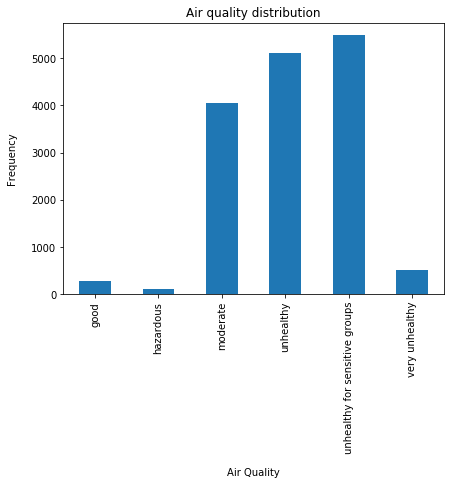

In [20]:
plt.subplot(1, 2, 1)
y.value_counts().sort_index().plot(
                                                kind = 'bar',
                                                figsize = (15,5))

plt.title("Air quality distribution")
plt.xlabel("Air Quality", labelpad = 14)
plt.ylabel("Frequency", labelpad = 14);

#### 2.2 DATA STANDARIZATION

In [21]:
# apply standardisation to the feature values
scaler = MinMaxScaler()
scaler = scaler.fit(x)

x[:] = scaler.transform(x)
test[:] = scaler.transform(test)

x.describe()

,max_temp,min_temp,mean_temp,std_temp,var_temp,median_temp,max_precip,min_precip,mean_precip,std_precip,...,mean_wind_spd,std_wind_spd,var_wind_spd,median_wind_spd,max_atmos_press,min_atmos_press,mean_atmos_press,std_atmos_press,var_atmos_press,median_atmos_press
count,15539.000000,15539.000000,15539.000000,15539.000000,15539.000000,15539.000000,15539.000000,15539.0,15539.000000,15539.000000,...,15539.000000,15539.000000,15539.000000,15539.000000,15539.000000,15539.000000,15539.000000,15539.000000,15539.000000,15539.000000
mean,0.584197,0.553896,0.466420,0.522111,0.331460,0.436412,0.177256,0.0,0.071581,0.161325,...,0.118458,0.170838,0.048145,0.101902,0.450207,0.445363,0.447287,0.383244,0.249885,0.449840
std,0.128265,0.156716,0.147025,0.133369,0.141993,0.175946,0.201235,0.0,0.088255,0.178682,...,0.117591,0.076555,0.046217,0.118893,0.337412,0.322091,0.336545,0.105336,0.094798,0.335256
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.484488,0.449878,0.342000,0.428335,0.226874,0.286598,0.018175,0.0,0.006316,0.016836,...,0.070129,0.121723,0.025129,0.054757,0.228075,0.228484,0.228891,0.310448,0.183721,0.234213
50%,0.580357,0.548900,0.466231,0.512363,0.306803,0.438144,0.118059,0.0,0.041050,0.108013,...,0.091786,0.158431,0.037962,0.071041,0.271797,0.287654,0.272037,0.378236,0.239016,0.274845
75%,0.667659,0.662592,0.570845,0.614521,0.419626,0.571134,0.253638,0.0,0.107528,0.241665,...,0.122687,0.205463,0.057963,0.104406,0.904372,0.865779,0.897532,0.447829,0.301443,0.898551
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [22]:
#ONE-HOT ENCODE THE TARGET VARIABLES
y = pd.get_dummies(y, drop_first=False)

#print one-hot encoded target values
y

,good,hazardous,moderate,unhealthy,unhealthy for sensitive groups,very unhealthy
0,0,0,0,0,1,0
1,0,0,0,1,0,0
2,0,0,1,0,0,0
3,0,0,0,0,1,0
4,0,0,0,0,0,1
...,...,...,...,...,...,...
15534,0,0,0,0,1,0
15535,0,0,1,0,0,0
15536,0,0,0,0,1,0
15537,0,0,0,0,1,0


### 3. RECURRENT  NEURAL NETWORK (RNN)

The Keras API, [`tf.keras.Sequential`](https://www.tensorflow.org/api_docs/python/tf/keras/models/Sequential), is used to define the model.

#### 3.1 DEFINE THE RNN MODEL

In [23]:
# Defins the RNN Model
def get_sequential_rnn(input_size, output_size, units=36, learning_rate=0.001):

    model = tf.keras.Sequential([
                # Defines Input sequence for the model
                tf.keras.layers.Input(shape=(None, input_size), dtype='float32'),
                
                # Defines the 1st LSTM layer with 25% dropout.
                tf.keras.layers.LSTM(units=units,
                                     return_sequences=True,
                                     recurrent_dropout=0.25,
                                     recurrent_initializer='glorot_uniform'),
                tf.keras.layers.Dropout(0.25, name="dropout_1"),
        
                # Defines the 2nd LSTM layer with 50% dropout.
                tf.keras.layers.LSTM(units=units,
                                     return_sequences=True,
                                     recurrent_dropout=0.5,
                                     recurrent_initializer='glorot_uniform'),
                tf.keras.layers.Dropout(0.5, name="dropout_2"),
        
                # Dense layer (output layer).
                tf.keras.layers.Dense(output_size, activation='softmax')])

    model.compile(loss='mse',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])

    return model



rnn_model = get_sequential_rnn(x.shape[1], y.shape[1])
rnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 36)          10512     
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 36)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 36)          10512     
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 36)          0         
_________________________________________________________________
dense (Dense)                (None, None, 6)           222       
Total params: 21,246
Trainable params: 21,246
Non-trainable params: 0
_________________________________________________________________


In [17]:
# **Checking output dimensionality.**

#Collects a random sample of size 15 from the training dataset
tmp = x.sample(15).values

result = rnn_model(np.reshape(tmp, (tmp.shape[0], 1, tmp.shape[1])))
result.shape, result.dtype


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



(TensorShape([15, 1, 6]), tf.float32)

In [18]:
#**Predictions from the untrained model.**

sampled = tf.squeeze(
                tf.random.categorical(result[0], num_samples=1),
                axis=-1).numpy()
sampled

array([1])

#### 3.2 TRAINING THE MODEL

In [24]:
def plot_history(history):
    rmse = history['root_mean_squared_error']
    v_rmse = history['val_root_mean_squared_error']

    mse = history['loss']
    v_mse = history['val_loss']
    x = range(1, len(rmse) + 1)

    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.title('Root Mean Squared Error (RMSE)')
    plt.plot(x, rmse, 'b', label='Training RMSE')
    plt.plot(x, v_rmse, 'r', label='Validation RMSE')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title('Mean Squared Error MSE loss')
    plt.plot(x, mse, 'b', label='Training MSE loss')
    plt.plot(x, v_mse, 'r', label='Validation MSE loss')
    plt.legend()


In [25]:
"""** Collects a random sample of the specified "sample_size" from the training 
      dataset and reshapes it"""

def get_sample(x, y, sample_size):
    seed = np.random.randint(150)
    assert x.shape[0] == y.shape[0]

    x_batch = x.sample(n=sample_size, random_state=seed).values
    y_batch = y.sample(n=sample_size, random_state=seed).values

    return (np.reshape(x_batch, (sample_size, 1, x_batch.shape[1])),
            np.reshape(y_batch, (sample_size, 1, y_batch.shape[1])))


In [29]:
#Hyperparameter optimization

UNITS = 60
EPOTCHS = 200
BATCH_SIZE = 55

INPUT_SIZE = x.shape[1]
OUTPUT_SIZE = y.shape[1]
LEARNING_RATE = 0.001

#Rebuilding the RNN model
rnn_model = get_sequential_rnn(INPUT_SIZE,
                               OUTPUT_SIZE,
                               units = UNITS,
                               learning_rate = LEARNING_RATE)

# While testing and you don't want to fit the whole dataset.
# this is the guy to call. :).
x_sample, y_sample = get_sample(x, y, sample_size=7500)

#Fitting the sample data in the model
history = rnn_model.fit(x_sample,
                        y_sample,
                        epochs = EPOTCHS,
                        batch_size = BATCH_SIZE,
                        validation_split = 0.2)


Train on 6000 samples, validate on 1500 samples
Epoch 1/200
6000/6000 [==============================] - 8s 1ms/sample - loss: 0.1223 - root_mean_squared_error: 0.3496 - val_loss: 0.1154 - val_root_mean_squared_error: 0.3397
Epoch 2/200
6000/6000 [==============================] - 3s 437us/sample - loss: 0.1162 - root_mean_squared_error: 0.3409 - val_loss: 0.1147 - val_root_mean_squared_error: 0.3386
Epoch 3/200
6000/6000 [==============================] - 3s 428us/sample - loss: 0.1144 - root_mean_squared_error: 0.3383 - val_loss: 0.1132 - val_root_mean_squared_error: 0.3365
Epoch 4/200
6000/6000 [==============================] - 2s 385us/sample - loss: 0.1127 - root_mean_squared_error: 0.3357 - val_loss: 0.1125 - val_root_mean_squared_error: 0.3354
Epoch 5/200
6000/6000 [==============================] - 2s 355us/sample - loss: 0.1121 - root_mean_squared_error: 0.3348 - val_loss: 0.1126 - val_root_mean_squared_error: 0.3355
Epoch 6/200
6000/6000 [==============================] - 2s

6000/6000 [==============================] - 2s 329us/sample - loss: 0.1048 - root_mean_squared_error: 0.3237 - val_loss: 0.1067 - val_root_mean_squared_error: 0.3266
Epoch 47/200
6000/6000 [==============================] - 2s 347us/sample - loss: 0.1048 - root_mean_squared_error: 0.3237 - val_loss: 0.1057 - val_root_mean_squared_error: 0.3252
Epoch 48/200
6000/6000 [==============================] - 2s 321us/sample - loss: 0.1049 - root_mean_squared_error: 0.3238 - val_loss: 0.1056 - val_root_mean_squared_error: 0.3250
Epoch 49/200
6000/6000 [==============================] - 2s 373us/sample - loss: 0.1042 - root_mean_squared_error: 0.3227 - val_loss: 0.1057 - val_root_mean_squared_error: 0.3251
Epoch 50/200
6000/6000 [==============================] - 3s 472us/sample - loss: 0.1042 - root_mean_squared_error: 0.3228 - val_loss: 0.1056 - val_root_mean_squared_error: 0.3249
Epoch 51/200
6000/6000 [==============================] - 2s 349us/sample - loss: 0.1041 - root_mean_squared_erro

6000/6000 [==============================] - 2s 360us/sample - loss: 0.1019 - root_mean_squared_error: 0.3193 - val_loss: 0.1031 - val_root_mean_squared_error: 0.3211
Epoch 92/200
6000/6000 [==============================] - 2s 359us/sample - loss: 0.1023 - root_mean_squared_error: 0.3198 - val_loss: 0.1033 - val_root_mean_squared_error: 0.3213
Epoch 93/200
6000/6000 [==============================] - 2s 344us/sample - loss: 0.1020 - root_mean_squared_error: 0.3194 - val_loss: 0.1040 - val_root_mean_squared_error: 0.3224
Epoch 94/200
6000/6000 [==============================] - 2s 319us/sample - loss: 0.1022 - root_mean_squared_error: 0.3196 - val_loss: 0.1031 - val_root_mean_squared_error: 0.3211
Epoch 95/200
6000/6000 [==============================] - 2s 327us/sample - loss: 0.1019 - root_mean_squared_error: 0.3192 - val_loss: 0.1031 - val_root_mean_squared_error: 0.3210
Epoch 96/200
6000/6000 [==============================] - 2s 337us/sample - loss: 0.1019 - root_mean_squared_erro

6000/6000 [==============================] - 2s 356us/sample - loss: 0.1002 - root_mean_squared_error: 0.3165 - val_loss: 0.1019 - val_root_mean_squared_error: 0.3192
Epoch 137/200
6000/6000 [==============================] - 2s 412us/sample - loss: 0.1008 - root_mean_squared_error: 0.3175 - val_loss: 0.1022 - val_root_mean_squared_error: 0.3197
Epoch 138/200
6000/6000 [==============================] - 2s 389us/sample - loss: 0.1006 - root_mean_squared_error: 0.3172 - val_loss: 0.1020 - val_root_mean_squared_error: 0.3194
Epoch 139/200
6000/6000 [==============================] - 2s 339us/sample - loss: 0.1008 - root_mean_squared_error: 0.3174 - val_loss: 0.1022 - val_root_mean_squared_error: 0.3196
Epoch 140/200
6000/6000 [==============================] - 2s 363us/sample - loss: 0.1006 - root_mean_squared_error: 0.3172 - val_loss: 0.1023 - val_root_mean_squared_error: 0.3198
Epoch 141/200
6000/6000 [==============================] - 2s 295us/sample - loss: 0.1007 - root_mean_squared

6000/6000 [==============================] - 2s 323us/sample - loss: 0.0995 - root_mean_squared_error: 0.3154 - val_loss: 0.1014 - val_root_mean_squared_error: 0.3184
Epoch 182/200
6000/6000 [==============================] - 2s 349us/sample - loss: 0.0992 - root_mean_squared_error: 0.3149 - val_loss: 0.1011 - val_root_mean_squared_error: 0.3180
Epoch 183/200
6000/6000 [==============================] - 2s 322us/sample - loss: 0.0992 - root_mean_squared_error: 0.3149 - val_loss: 0.1032 - val_root_mean_squared_error: 0.3213
Epoch 184/200
6000/6000 [==============================] - 2s 321us/sample - loss: 0.0991 - root_mean_squared_error: 0.3148 - val_loss: 0.1015 - val_root_mean_squared_error: 0.3185
Epoch 185/200
6000/6000 [==============================] - 2s 351us/sample - loss: 0.0995 - root_mean_squared_error: 0.3155 - val_loss: 0.1011 - val_root_mean_squared_error: 0.3180
Epoch 186/200
6000/6000 [==============================] - 2s 326us/sample - loss: 0.0994 - root_mean_squared

In [31]:
# Evaluate the RNN model
mse, rmse = rnn_model.evaluate(x_sample, y_sample, verbose = False)
print("{:25}: {:.4f}\n{:25}: {:.4f}".format("Root Mean Squared Error", rmse, 
                                            "Mean Squared Error", mse))


Root Mean Squared Error  : 0.3133
Mean Squared Error       : 0.0982


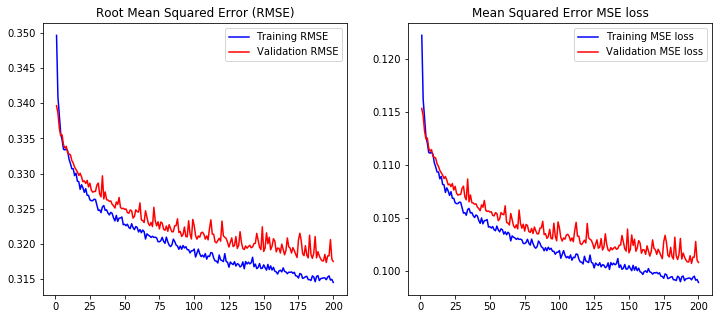

In [32]:
plot_history(history.history)

### 4. Convolutional Neural Network (CNN)


#### 4.1 DEFINE THE CNN MODEL

In [36]:
def get_sequential_cnn(input_size, output_size, learning_rate=0.001):
    
    model = tf.keras.Sequential([
                #Defines Input sequence for the model
                tf.keras.layers.Input(shape=(None, input_size)),

                #Defines 1D Conv 1st block
                tf.keras.layers.Conv1D(filters=input_size, kernel_size=1, activation='relu'),
                tf.keras.layers.Dropout(0.2, name="dropout_1"),
                tf.keras.layers.MaxPooling1D(pool_size=1),

                #Defines 1D Conv 2nd block
                tf.keras.layers.Conv1D(filters=126, kernel_size=1, activation='relu'),
                tf.keras.layers.MaxPooling1D(pool_size=1),

                #Defines 1D Conv 3rd block
                tf.keras.layers.Conv1D(filters=36, kernel_size=1, activation='relu'),
                tf.keras.layers.Dropout(0.5, name="dropout_2"),
                tf.keras.layers.MaxPooling1D(pool_size=1),

                # Final block, Dense output with softmax activation.
                tf.keras.layers.Dense(30, activation="relu"),
                tf.keras.layers.Dense(output_size, activation='softmax')])

    model.compile(loss='mse',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])

    return model


cnn_model = get_sequential_cnn(x.shape[1], y.shape[1])
cnn_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, None, 36)          1332      
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 36)          0         
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, None, 36)          0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, None, 126)         4662      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, None, 126)         0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, None, 36)          4572      
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 36)         

In [27]:
# **Checking output dimensionality.**

#Collects a random sample of size 15 from the training dataset
tmp = x.sample(15).values

result = cnn_model(np.reshape(tmp, (tmp.shape[0], 1, tmp.shape[1])))
result.shape, result.dtype


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



(TensorShape([15, 1, 6]), tf.float32)

In [28]:
#**Predictions from the untrained model.**

sampled = tf.squeeze(
                tf.random.categorical(result[0], num_samples=1),
                axis=-1).numpy()
sampled

array([3])

#### 4.2 TRAINING THE MODEL

In [37]:
#Hyperparameter optimization

EPOTCHS = 200
BATCH_SIZE = 45

INPUT_SIZE = x.shape[1]
OUTPUT_SIZE = y.shape[1]
LEARNING_RATE = 0.001

#Rebuilding the CNN model
cnn_model = get_sequential_cnn(INPUT_SIZE,
                               OUTPUT_SIZE,
                               learning_rate=LEARNING_RATE)

#
x_sample, y_sample = get_sample(x, y, sample_size=7500)

#Fitting the sample data in the model
history = cnn_model.fit(
                    x_sample,
                    y_sample,
                    epochs=EPOTCHS,
                    batch_size=BATCH_SIZE,
                    validation_split = 0.2)


Train on 6000 samples, validate on 1500 samples
Epoch 1/200
6000/6000 [==============================] - 8s 1ms/sample - loss: 0.1210 - root_mean_squared_error: 0.3478 - val_loss: 0.1159 - val_root_mean_squared_error: 0.3404
Epoch 2/200
6000/6000 [==============================] - 5s 895us/sample - loss: 0.1157 - root_mean_squared_error: 0.3401 - val_loss: 0.1149 - val_root_mean_squared_error: 0.3390
Epoch 3/200
6000/6000 [==============================] - 4s 679us/sample - loss: 0.1145 - root_mean_squared_error: 0.3383 - val_loss: 0.1131 - val_root_mean_squared_error: 0.3364
Epoch 4/200
6000/6000 [==============================] - 6s 949us/sample - loss: 0.1139 - root_mean_squared_error: 0.3375 - val_loss: 0.1120 - val_root_mean_squared_error: 0.3347
Epoch 5/200
6000/6000 [==============================] - 5s 783us/sample - loss: 0.1130 - root_mean_squared_error: 0.3361 - val_loss: 0.1116 - val_root_mean_squared_error: 0.3341
Epoch 6/200
6000/6000 [==============================] - 7s

6000/6000 [==============================] - 4s 603us/sample - loss: 0.1034 - root_mean_squared_error: 0.3215 - val_loss: 0.1021 - val_root_mean_squared_error: 0.3195
Epoch 47/200
6000/6000 [==============================] - 5s 796us/sample - loss: 0.1033 - root_mean_squared_error: 0.3215 - val_loss: 0.1014 - val_root_mean_squared_error: 0.3185
Epoch 48/200
6000/6000 [==============================] - 6s 947us/sample - loss: 0.1036 - root_mean_squared_error: 0.3219 - val_loss: 0.1015 - val_root_mean_squared_error: 0.3186
Epoch 49/200
6000/6000 [==============================] - 6s 962us/sample - loss: 0.1027 - root_mean_squared_error: 0.3204 - val_loss: 0.1015 - val_root_mean_squared_error: 0.3186
Epoch 50/200
6000/6000 [==============================] - 4s 716us/sample - loss: 0.1031 - root_mean_squared_error: 0.3211 - val_loss: 0.1017 - val_root_mean_squared_error: 0.3188
Epoch 51/200
6000/6000 [==============================] - 5s 878us/sample - loss: 0.1026 - root_mean_squared_erro

Epoch 92/200
6000/6000 [==============================] - 4s 702us/sample - loss: 0.1002 - root_mean_squared_error: 0.3165 - val_loss: 0.0997 - val_root_mean_squared_error: 0.3157
Epoch 93/200
6000/6000 [==============================] - 6s 925us/sample - loss: 0.1005 - root_mean_squared_error: 0.3170 - val_loss: 0.0998 - val_root_mean_squared_error: 0.3159
Epoch 94/200
6000/6000 [==============================] - 4s 687us/sample - loss: 0.1006 - root_mean_squared_error: 0.3171 - val_loss: 0.1004 - val_root_mean_squared_error: 0.3168
Epoch 95/200
6000/6000 [==============================] - 6s 958us/sample - loss: 0.1004 - root_mean_squared_error: 0.3168 - val_loss: 0.1005 - val_root_mean_squared_error: 0.3170
Epoch 96/200
6000/6000 [==============================] - 4s 682us/sample - loss: 0.1006 - root_mean_squared_error: 0.3171 - val_loss: 0.1005 - val_root_mean_squared_error: 0.3170
Epoch 97/200
6000/6000 [==============================] - 4s 721us/sample - loss: 0.0999 - root_mean

6000/6000 [==============================] - 3s 517us/sample - loss: 0.0988 - root_mean_squared_error: 0.3143 - val_loss: 0.0995 - val_root_mean_squared_error: 0.3154
Epoch 138/200
6000/6000 [==============================] - 5s 911us/sample - loss: 0.0991 - root_mean_squared_error: 0.3149 - val_loss: 0.0992 - val_root_mean_squared_error: 0.3150
Epoch 139/200
6000/6000 [==============================] - 4s 695us/sample - loss: 0.0980 - root_mean_squared_error: 0.3131 - val_loss: 0.1003 - val_root_mean_squared_error: 0.3166
Epoch 140/200
6000/6000 [==============================] - 6s 994us/sample - loss: 0.0993 - root_mean_squared_error: 0.3152 - val_loss: 0.0990 - val_root_mean_squared_error: 0.3146
Epoch 141/200
6000/6000 [==============================] - 4s 746us/sample - loss: 0.0989 - root_mean_squared_error: 0.3144 - val_loss: 0.0993 - val_root_mean_squared_error: 0.3151
Epoch 142/200
6000/6000 [==============================] - 5s 843us/sample - loss: 0.0983 - root_mean_squared

6000/6000 [==============================] - 6s 917us/sample - loss: 0.0974 - root_mean_squared_error: 0.3121 - val_loss: 0.0981 - val_root_mean_squared_error: 0.3132
Epoch 183/200
6000/6000 [==============================] - 5s 846us/sample - loss: 0.0974 - root_mean_squared_error: 0.3121 - val_loss: 0.0990 - val_root_mean_squared_error: 0.3146
Epoch 184/200
6000/6000 [==============================] - 5s 766us/sample - loss: 0.0981 - root_mean_squared_error: 0.3133 - val_loss: 0.0987 - val_root_mean_squared_error: 0.3142
Epoch 185/200
6000/6000 [==============================] - 4s 681us/sample - loss: 0.0975 - root_mean_squared_error: 0.3123 - val_loss: 0.0988 - val_root_mean_squared_error: 0.3143
Epoch 186/200
6000/6000 [==============================] - 4s 599us/sample - loss: 0.0970 - root_mean_squared_error: 0.3114 - val_loss: 0.0990 - val_root_mean_squared_error: 0.3146
Epoch 187/200
6000/6000 [==============================] - 5s 863us/sample - loss: 0.0979 - root_mean_squared

In [38]:
# Evaluate the model
mse, rmse = cnn_model.evaluate(x_sample, y_sample, verbose = False)
print("{:25}: {:.4f}\n{:25}: {:.4f}".format("Root Mean Squared Error", rmse, 
                                            "Mean Squared Error", mse))

Root Mean Squared Error  : 0.3080
Mean Squared Error       : 0.0949


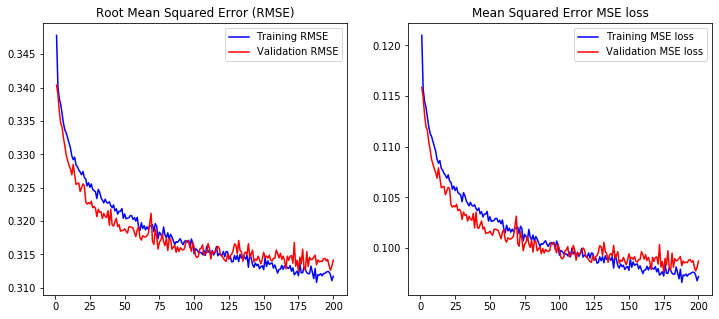

In [39]:
plot_history(history.history)